### Importing Required Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [2]:
device = "cuda" if torch.cuda.is_available() else 'cpu'
device

'cuda'

### Defining the seed

In [3]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
random.seed(42)

### Defining the model and training parameters

In [4]:
BATCH_SIZE = 128
LEARNING_RATE = 3e-4
PATCH_SIZE = 4
NUM_CLASSES = 10
IMAGE_SIZE = 32
CHANNELS = 3
EMBED_DIM = 256
NUM_HEAD = 8
DEPTH = 6
MLP_DIM = 512
DROP_RATE = 0.1

### Initial Transformations applied to test and train data

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                     std=[0.2023, 0.1994, 0.2010])
])

### Loading the dataset and defining the train and test loader

In [6]:
def load_data(transformation):
  train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transformation)
  test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transformation)
  train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
  test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
  return train_dataset, test_dataset, train_loader, test_loader

In [7]:
train_dataset, test_dataset, train_loader, test_loader = load_data(transform)

100%|██████████| 170M/170M [00:03<00:00, 43.7MB/s]


### Defining PatchEmbedding module that splits an image into patches using a convolution layer, flattens them into embeddings, adds a learnable class token and positional encodings, and outputs the sequence for a Vision Transformer.

In [8]:
class PatchEmbedding(nn.Module):
    def __init__(self, img_size, patch_size, in_channels, embed_dim, stride=None):
        super().__init__()
        self.patch_size = patch_size
        self.stride = stride if stride is not None else patch_size

        self.proj = nn.Conv2d(
            in_channels=in_channels,
            out_channels=embed_dim,
            kernel_size=patch_size,
            stride=self.stride
        )

        # Compute number of patches per dimension
        num_patches_per_dim = ((img_size - patch_size) // self.stride) + 1
        num_patches = num_patches_per_dim ** 2

        # Class token + positional embedding
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.randn(1, 1 + num_patches, embed_dim))

    def forward(self, x: torch.Tensor):
        B = x.size(0)
        x = self.proj(x)                        # [B, embed_dim, H', W']
        x = x.flatten(2).transpose(1, 2)        # [B, num_patches, embed_dim]
        cls_token = self.cls_token.expand(B, -1, -1)
        x = torch.cat([cls_token, x], dim=1)    # [B, 1+num_patches, embed_dim]
        x = x + self.pos_embed
        return x


In [9]:
class MLP(nn.Module):
  def __init__(self,
               in_features,
               hidden_features,
               drop_rate):
    super().__init__()
    self.fc1 = nn.Linear(in_features=in_features,
                         out_features=hidden_features)
    self.drop = nn.Dropout(p=drop_rate)
    self.fc2 = nn.Linear(in_features=hidden_features,
                         out_features=in_features)

  def forward(self, x):
    x = self.drop(F.gelu(self.fc1(x)))
    x = self.drop(self.fc2(x))
    return x

### Implementing a Multi-Head Self-Attention layer, which projects input embeddings into queries, keys, and values, computes scaled dot-product attention across multiple heads, and combines the results into the output embedding.

In [10]:
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout=0.0):
        super().__init__()
        # Ensure embedding dimension is divisible by number of heads
        assert embed_dim % num_heads == 0, "embed_dim must be divisible by num_heads"

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads  # Dimension per head

        # Linear layer to compute queries, keys, and values in one go
        self.qkv = nn.Linear(embed_dim, embed_dim * 3)
        self.proj = nn.Linear(embed_dim, embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, N, D = x.shape  # B: batch size, N: sequence length, D: embedding dim

        # Compute queries, keys, values and reshape for multi-head attention
        qkv = self.qkv(x)  # Shape: (B, N, 3*D)
        qkv = qkv.reshape(B, N, 3, self.num_heads, self.head_dim)  # (B, N, 3, num_heads, head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)  # Rearrange to (3, B, num_heads, N, head_dim)
        Q, K, V = qkv[0], qkv[1], qkv[2]  # Split into queries, keys, and values

        # Compute scaled dot-product attention
        scores = (Q @ K.transpose(-2, -1)) / (self.head_dim ** 0.5)  # (B, num_heads, N, N)
        attn = F.softmax(scores, dim=-1)
        attn = self.dropout(attn)

        out = attn @ V  # (B, num_heads, N, head_dim)

        # Concatenate heads and reshape back to (B, N, D)
        out = out.transpose(1, 2).reshape(B, N, D)

        # Final linear projection
        out = self.proj(out)
        return out


### Defining Transformer Encoder Layer, which applies layer normalization, multi-head self-attention, and a feed-forward MLP with residual connections to process input embeddings.

In [11]:
class TransformerEncoderLayer(nn.Module):
  def __init__(self, embed_dim, num_head, mlp_dim,drop_rate):
    super().__init__()
    self.norm1 = nn.LayerNorm(embed_dim)
    self.attn = MultiHeadSelfAttention(embed_dim=embed_dim,
                                      num_heads=num_head,
                                      dropout=drop_rate)
    self.norm2 = nn.LayerNorm(embed_dim)
    self.mlp = MLP(embed_dim, mlp_dim, drop_rate)

  def forward(self, x):
    x = x + self.attn(self.norm1(x))
    x = x + self.mlp(self.norm2(x))
    return x

### Defining Vision Transformer (ViT) model that converts an image into patch embeddings, processes them through stacked transformer encoder layers, normalizes the output, and uses the class token for final classification.

In [12]:
class VisionTransformer(nn.Module):
  def __init__(self, img_size, patch_size, in_channels, num_classes, embed_dim, depth, num_heads, mlp_dim, drop_rate, stride = None):
    super().__init__()
    self.patch_embed = PatchEmbedding(img_size=img_size,
                                      patch_size=patch_size,
                                      in_channels=in_channels,
                                      embed_dim=embed_dim,
                                      stride = stride)
    self.encoder = nn.Sequential(
        *[TransformerEncoderLayer(embed_dim, num_heads, mlp_dim, drop_rate)
        for _ in range(depth)]
    )

    self.norm = nn.LayerNorm(embed_dim)
    self.head = nn.Linear(embed_dim, num_classes)

  def forward(self,x):
    x = self.patch_embed(x)
    x = self.encoder(x)
    x = self.norm(x)
    cls_token = x[:,0]
    return self.head(cls_token)

### Inistantiating our baseline model

In [13]:
model = VisionTransformer(
    IMAGE_SIZE, PATCH_SIZE, CHANNELS,NUM_CLASSES,
    EMBED_DIM, DEPTH, NUM_HEAD, MLP_DIM, DROP_RATE
).to(device)

In [14]:
model

VisionTransformer(
  (patch_embed): PatchEmbedding(
    (proj): Conv2d(3, 256, kernel_size=(4, 4), stride=(4, 4))
  )
  (encoder): Sequential(
    (0): TransformerEncoderLayer(
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (attn): MultiHeadSelfAttention(
        (qkv): Linear(in_features=256, out_features=768, bias=True)
        (proj): Linear(in_features=256, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (mlp): MLP(
        (fc1): Linear(in_features=256, out_features=512, bias=True)
        (drop): Dropout(p=0.1, inplace=False)
        (fc2): Linear(in_features=512, out_features=256, bias=True)
      )
    )
    (1): TransformerEncoderLayer(
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (attn): MultiHeadSelfAttention(
        (qkv): Linear(in_features=256, out_features=768, bias=True)
        (proj): Linear(in_feat

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params = model.parameters(), lr = LEARNING_RATE)

### This function trains a PyTorch model for one epoch, updating weights, computing loss, and returning the average loss and accuracy.

In [16]:
def train(model, loader, optimizer, criterion, scheduler=None):
    model.train()  # Set model to training mode

    total_loss = 0
    total_correct = 0

    for data, target in loader:
        data, target = data.to(device), target.to(device)  # Move to GPU if available
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, target)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * data.size(0)  # Accumulate loss
        _, pred = torch.max(out.data, 1)          # Get predictions
        total_correct += (pred == target).sum().item()  # Count correct predictions

    # Return average loss and accuracy
    return total_loss / len(loader.dataset), total_correct / len(loader.dataset)


### This function evaluates a PyTorch model on a dataset, returning its accuracy without updating the model’s weights.

In [17]:
def evaluate(model, loader):
    model.eval()  # Set model to evaluation mode (disables dropout, etc.)
    correct = 0

    with torch.inference_mode():  # Disable gradient computation for efficiency
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            out = model(data)
            correct += (out.argmax(dim=1) == target).sum().item()  # Count correct predictions

    return correct / len(loader.dataset)

### This function trains a model for multiple epochs, tracks training and test accuracies, and prints progress after each epoch.

In [18]:
def train_model(model, optimizer, criterion, epochs=15, scheduler=None):
    train_accuracies = []
    test_accuracies = []

    for epoch in tqdm(range(epochs)):
        # Train for one epoch
        train_loss, train_acc = train(model, train_loader, optimizer, criterion, scheduler)

        # Evaluate on test data
        test_acc = evaluate(model, test_loader)

        if scheduler:
            scheduler.step()

        # Store accuracies
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)

        # Print progress
        print(f"Epoch: {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")

    return train_accuracies, test_accuracies


In [19]:
train_accuracies, test_accuracies = train_model(model, optimizer, criterion)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1/15, Train Loss: 1.6108, Train Acc: 0.4131, Test Acc: 0.5183
Epoch: 2/15, Train Loss: 1.2432, Train Acc: 0.5534, Test Acc: 0.5735
Epoch: 3/15, Train Loss: 1.0959, Train Acc: 0.6078, Test Acc: 0.5854
Epoch: 4/15, Train Loss: 0.9872, Train Acc: 0.6479, Test Acc: 0.6167
Epoch: 5/15, Train Loss: 0.8945, Train Acc: 0.6801, Test Acc: 0.6433
Epoch: 6/15, Train Loss: 0.8085, Train Acc: 0.7120, Test Acc: 0.6438
Epoch: 7/15, Train Loss: 0.7214, Train Acc: 0.7448, Test Acc: 0.6549
Epoch: 8/15, Train Loss: 0.6431, Train Acc: 0.7711, Test Acc: 0.6566
Epoch: 9/15, Train Loss: 0.5636, Train Acc: 0.7996, Test Acc: 0.6558
Epoch: 10/15, Train Loss: 0.4959, Train Acc: 0.8210, Test Acc: 0.6632
Epoch: 11/15, Train Loss: 0.4234, Train Acc: 0.8481, Test Acc: 0.6628
Epoch: 12/15, Train Loss: 0.3662, Train Acc: 0.8693, Test Acc: 0.6588
Epoch: 13/15, Train Loss: 0.3097, Train Acc: 0.8887, Test Acc: 0.6583
Epoch: 14/15, Train Loss: 0.2730, Train Acc: 0.9012, Test Acc: 0.6584
Epoch: 15/15, Train Loss: 0.2

### Ploting the Epoch vs Accuracy for visualizing the trend

In [20]:
def Accuracy_plot(train_accuracies, test_accuracies):
  plt.figure(figsize = (10,7))
  plt.plot(train_accuracies, label = 'Train_accuracies')
  plt.plot(test_accuracies, label = 'Test_accuracies')
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.legend()
  plt.title("Trainig and Test Accuracy")
  plt.show()

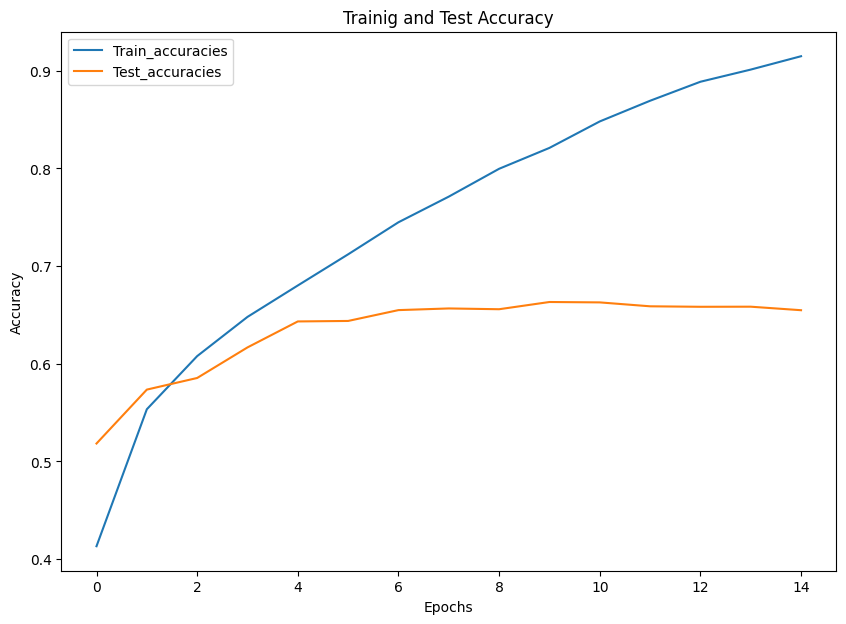

In [21]:
Accuracy_plot(train_accuracies, test_accuracies)

### Calculating the total accuracy considering the complete test datatset

In [24]:
def total_test_accuracy(model):
    overall_test_accuracy = None
    total_correct = 0
    model.eval()  # Set model to evaluation mode

    for data, image in test_loader:
        data, image = data.to(device), image.to(device)  # Move to GPU if available
        out = model(data)
        _, predicted = torch.max(out.data, 1)  # Get predicted class
        total_correct += (predicted == image).sum().item()  # Count correct predictions

    # Compute overall accuracy as a percentage
    overall_test_accuracy = total_correct / len(test_loader.dataset)
    return overall_test_accuracy * 100


In [25]:
inital_accuracy = total_test_accuracy(model)
inital_accuracy

65.48

# Experiments

### 1. Let's apply some Data Augumentation technique

In [26]:
### Chaning transform variable
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                     std=[0.2023, 0.1994, 0.2010]) ## actual calculated statistics for the dataset
])

In [27]:
train_dataset, test_dataset, train_loader, test_loader = load_data(transform_train)

In [28]:
## Retraining the model
model_2 = VisionTransformer(
    IMAGE_SIZE, PATCH_SIZE, CHANNELS,NUM_CLASSES,
    EMBED_DIM, DEPTH, NUM_HEAD, MLP_DIM, DROP_RATE
).to(device)
optimizer_2 = optim.Adam(params = model_2.parameters(), lr = LEARNING_RATE)

In [29]:
epochs_model_2 = 15

In [30]:
train_accuracies, test_accuracies = train_model(model_2, optimizer_2, criterion, epochs_model_2)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1/15, Train Loss: 1.7761, Train Acc: 0.3445, Test Acc: 0.4398
Epoch: 2/15, Train Loss: 1.4998, Train Acc: 0.4574, Test Acc: 0.4920
Epoch: 3/15, Train Loss: 1.3945, Train Acc: 0.4986, Test Acc: 0.5046
Epoch: 4/15, Train Loss: 1.3095, Train Acc: 0.5307, Test Acc: 0.5529
Epoch: 5/15, Train Loss: 1.2454, Train Acc: 0.5532, Test Acc: 0.5677
Epoch: 6/15, Train Loss: 1.1858, Train Acc: 0.5751, Test Acc: 0.5814
Epoch: 7/15, Train Loss: 1.1342, Train Acc: 0.5939, Test Acc: 0.6058
Epoch: 8/15, Train Loss: 1.0801, Train Acc: 0.6148, Test Acc: 0.6161
Epoch: 9/15, Train Loss: 1.0427, Train Acc: 0.6282, Test Acc: 0.6399
Epoch: 10/15, Train Loss: 1.0020, Train Acc: 0.6419, Test Acc: 0.6421
Epoch: 11/15, Train Loss: 0.9763, Train Acc: 0.6528, Test Acc: 0.6563
Epoch: 12/15, Train Loss: 0.9397, Train Acc: 0.6660, Test Acc: 0.6677
Epoch: 13/15, Train Loss: 0.9093, Train Acc: 0.6753, Test Acc: 0.6753
Epoch: 14/15, Train Loss: 0.8836, Train Acc: 0.6882, Test Acc: 0.6848
Epoch: 15/15, Train Loss: 0.8

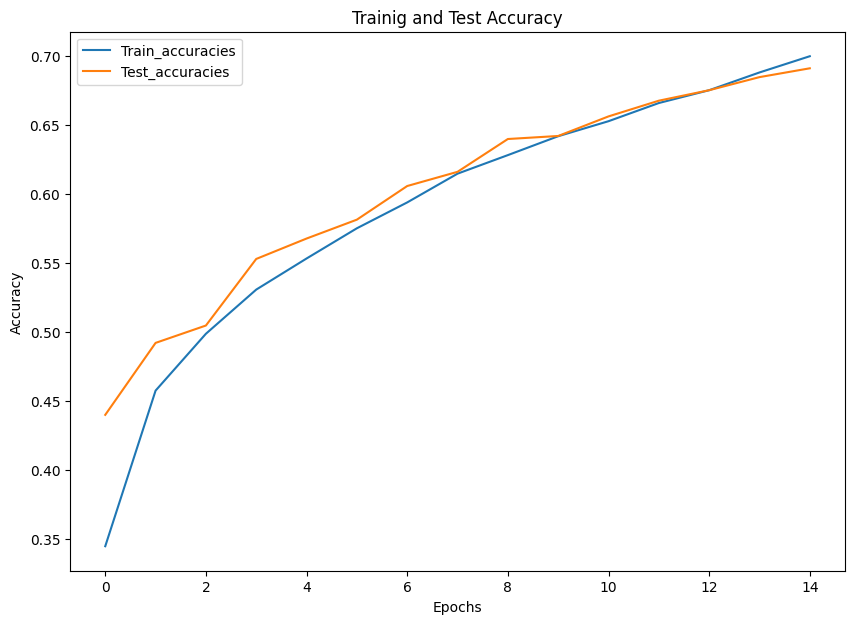

In [31]:
Accuracy_plot(train_accuracies, test_accuracies)

In [32]:
augemented_data_accuracy = total_test_accuracy(model_2)
augemented_data_accuracy

69.14

### 2. Let's use the AdamW optimizer with a scheduler and augmented data.

In [33]:
epochs_model_3 = 15

In [34]:
model_3 = VisionTransformer(
    IMAGE_SIZE, PATCH_SIZE, CHANNELS,NUM_CLASSES,
    EMBED_DIM, DEPTH, NUM_HEAD, MLP_DIM, DROP_RATE
).to(device)
optimizer_3 = optim.AdamW(model_3.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer_3, T_max=epochs_model_3)
criterion = nn.CrossEntropyLoss()

In [35]:
train_accuracies, test_accuracies = train_model(model_3, optimizer_3, criterion, epochs_model_3, scheduler)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1/15, Train Loss: 1.7918, Train Acc: 0.3447, Test Acc: 0.4278
Epoch: 2/15, Train Loss: 1.5094, Train Acc: 0.4568, Test Acc: 0.4858
Epoch: 3/15, Train Loss: 1.3857, Train Acc: 0.4999, Test Acc: 0.5176
Epoch: 4/15, Train Loss: 1.2891, Train Acc: 0.5382, Test Acc: 0.5545
Epoch: 5/15, Train Loss: 1.2116, Train Acc: 0.5646, Test Acc: 0.5902
Epoch: 6/15, Train Loss: 1.1518, Train Acc: 0.5888, Test Acc: 0.5956
Epoch: 7/15, Train Loss: 1.0894, Train Acc: 0.6107, Test Acc: 0.6199
Epoch: 8/15, Train Loss: 1.0442, Train Acc: 0.6270, Test Acc: 0.6351
Epoch: 9/15, Train Loss: 0.9928, Train Acc: 0.6474, Test Acc: 0.6485
Epoch: 10/15, Train Loss: 0.9560, Train Acc: 0.6600, Test Acc: 0.6651
Epoch: 11/15, Train Loss: 0.9192, Train Acc: 0.6748, Test Acc: 0.6661
Epoch: 12/15, Train Loss: 0.8855, Train Acc: 0.6852, Test Acc: 0.6779
Epoch: 13/15, Train Loss: 0.8722, Train Acc: 0.6909, Test Acc: 0.6854
Epoch: 14/15, Train Loss: 0.8524, Train Acc: 0.6974, Test Acc: 0.6891
Epoch: 15/15, Train Loss: 0.8

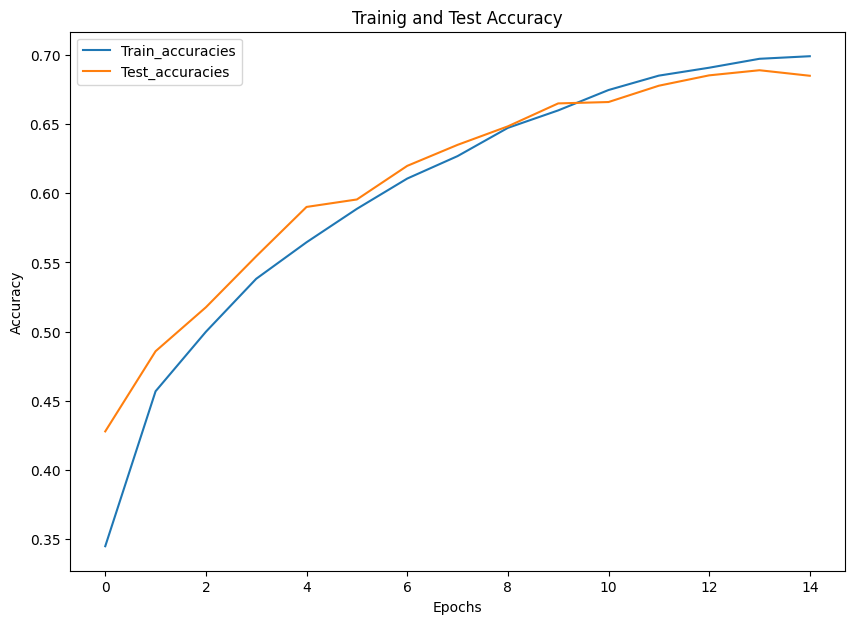

69.28

In [36]:
Accuracy_plot(train_accuracies, test_accuracies)
augumented_adamw_accuracy = total_test_accuracy(model_3)
augumented_adamw_accuracy

### 3. Let's do analysis with Overlapping Patches. Here we are using Adam instead of AdamW because we saw that it was giving less accuracy for same number of epochs

In [37]:
epochs_model_4 = 20

In [38]:
model_4 = VisionTransformer(
    IMAGE_SIZE, PATCH_SIZE, CHANNELS,NUM_CLASSES,
    EMBED_DIM, DEPTH, NUM_HEAD, MLP_DIM, DROP_RATE, stride = 2
).to(device)
optimizer_4 = optim.Adam(params = model_4.parameters(), lr = LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

In [39]:
train_accuracies, test_accuracies = train_model(model_4, optimizer_4, criterion, epochs_model_4)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1/20, Train Loss: 1.7769, Train Acc: 0.3459, Test Acc: 0.4405
Epoch: 2/20, Train Loss: 1.4646, Train Acc: 0.4699, Test Acc: 0.5146
Epoch: 3/20, Train Loss: 1.3007, Train Acc: 0.5350, Test Acc: 0.5624
Epoch: 4/20, Train Loss: 1.1998, Train Acc: 0.5708, Test Acc: 0.5891
Epoch: 5/20, Train Loss: 1.1092, Train Acc: 0.6038, Test Acc: 0.6151
Epoch: 6/20, Train Loss: 1.0383, Train Acc: 0.6286, Test Acc: 0.6273
Epoch: 7/20, Train Loss: 0.9798, Train Acc: 0.6542, Test Acc: 0.6672
Epoch: 8/20, Train Loss: 0.9272, Train Acc: 0.6707, Test Acc: 0.6725
Epoch: 9/20, Train Loss: 0.8908, Train Acc: 0.6834, Test Acc: 0.6941
Epoch: 10/20, Train Loss: 0.8462, Train Acc: 0.6983, Test Acc: 0.6967
Epoch: 11/20, Train Loss: 0.8144, Train Acc: 0.7124, Test Acc: 0.7169
Epoch: 12/20, Train Loss: 0.7804, Train Acc: 0.7237, Test Acc: 0.7206
Epoch: 13/20, Train Loss: 0.7562, Train Acc: 0.7324, Test Acc: 0.7270
Epoch: 14/20, Train Loss: 0.7233, Train Acc: 0.7443, Test Acc: 0.7311
Epoch: 15/20, Train Loss: 0.7

KeyboardInterrupt: 

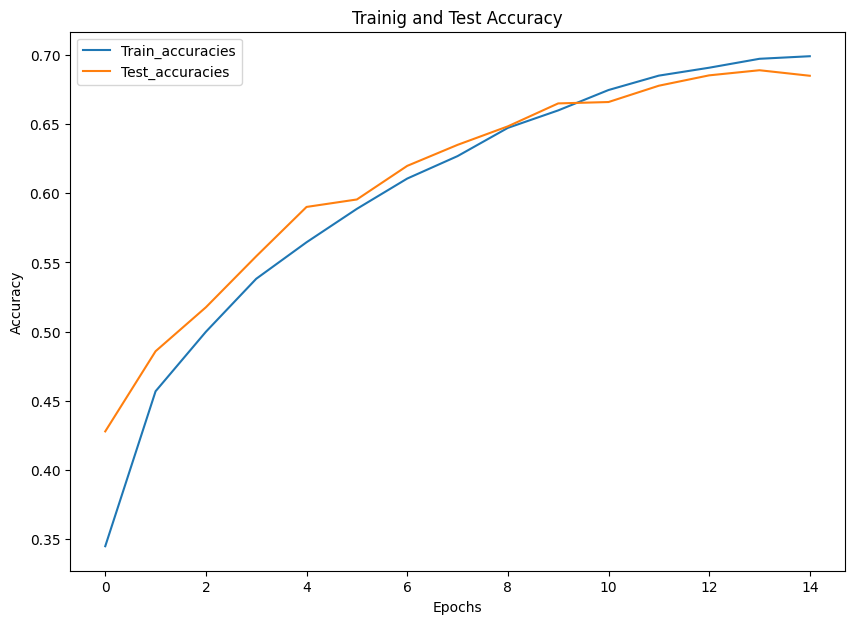

76.27000000000001

In [40]:
Accuracy_plot(train_accuracies, test_accuracies)
overlaped_patches_accuracy = total_test_accuracy(model_4)
overlaped_patches_accuracy

# Summary

In [42]:
import pandas as pd

results = {
    "Experiment": [
        "Baseline - Non Overlapping, No data augumentation (15 epochs)",
        "With Data Augmentation (15 epochs)",
        "Augmentation + AdamW + Scheduler (15 epochs)",
        "Augmentation + Overlapping Patches + Adam (20 epochs)"
    ],
    "Test Accuracy (%)": [
        65.48,
        69.14,
        69.28,
        76.27
    ]
}

df = pd.DataFrame(results)
from tabulate import tabulate
print(tabulate(df, headers='keys', tablefmt='pretty', showindex=False))


+---------------------------------------------------------------+-------------------+
|                          Experiment                           | Test Accuracy (%) |
+---------------------------------------------------------------+-------------------+
| Baseline - Non Overlapping, No data augumentation (15 epochs) |       65.48       |
|              With Data Augmentation (15 epochs)               |       69.14       |
|         Augmentation + AdamW + Scheduler (15 epochs)          |       69.28       |
|     Augmentation + Overlapping Patches + Adam (20 epochs)     |       76.27       |
+---------------------------------------------------------------+-------------------+


### Selecting random images from the dataset and predicted the label using our trained model

In [22]:
def predict_and_plot_grid(model,
                          dataset,
                          classes,
                          grid_size=3):
  model.eval()
  fig, axes = plt.subplots(grid_size, grid_size, figsize=(9,9))
  for i in range(grid_size):
    for j in range(grid_size):
      idx = random.randint(0, len(dataset)-1)
      img, true_label = dataset[idx]
      input_tensor = img.unsqueeze(dim = 0).to(device)
      with torch.inference_mode():
        output = model(input_tensor)
        _, predicted = torch.max(output.data, 1)
      img = img/2 + 0.5
      npimg = img.cpu().numpy()
      axes[i,j].imshow(np.transpose(npimg, (1,2,0)))
      truth = classes[true_label] == classes[predicted.item()]
      if truth:
        color = 'g'
      else:
        color = 'r'

      axes[i,j].set_title(f"Truth : {classes[true_label]}\n, Predicted: {classes[predicted.item()]}", fontsize = 10, c = color)
      axes[i,j].axis('off')
  plt.tight_layout()
  plt.show()

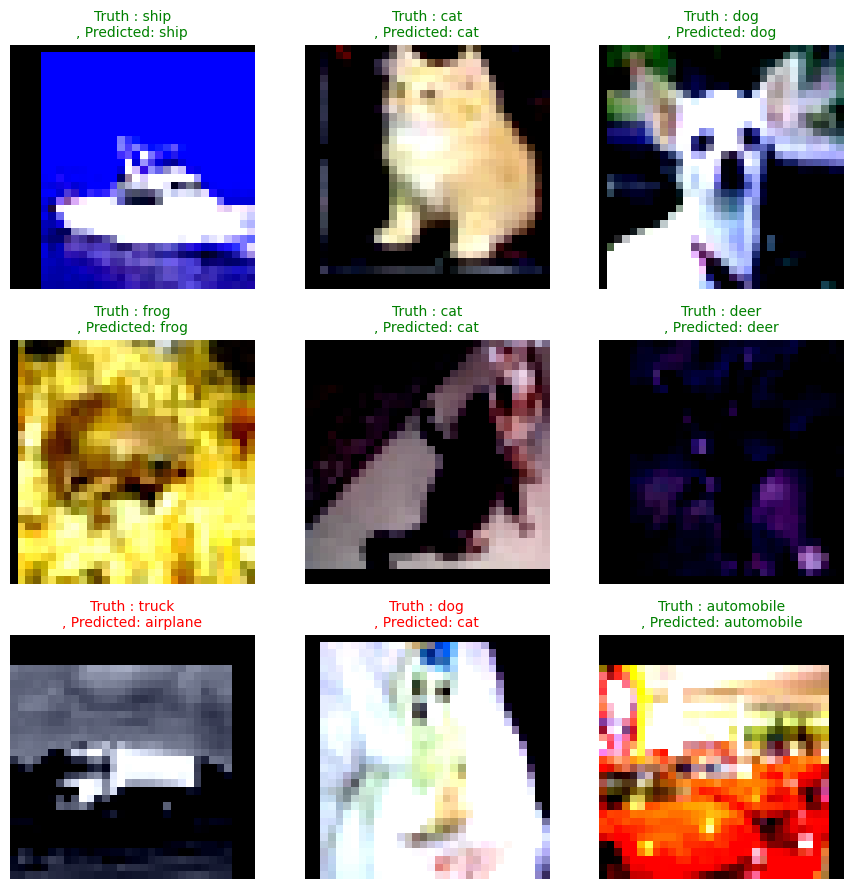

In [60]:
predict_and_plot_grid(model_4, test_dataset, test_dataset.classes)